توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
!pip install wget
import wget

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=bf61610663bd6586a7d5fadd33d390c711c55108856b4322b75601ce6b5941bd
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
--2023-12-22 10:16:08--  http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.131.233
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.131.233|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://data.csail.mit.edu/places/ADEchallenge/release_test.zip [following]
--2023-12-22 10:16:08--  https://data.csail.mit.edu/places/ADEchallenge/release_test.zip
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.131.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211820497 (202M) [application/zip]
Saving to: ‘release_test.zi

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt

import math
import psutil
import tqdm
from PIL import Image

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [3]:
# function 1
def displacement(img):
    ## displace image randomly
    dx = randint(-30,30)
    dy = randint(-30,30)
    rows,cols = img.shape[:2]
    M = np.float32([[1,0,dx],[0,1,dy]])
    img = cv2.warpAffine(img,M,(cols,rows))
    return img

# function 2
def rotation(img):
    ## rotate image randomly
    rows,cols = img.shape[:2]
    angle = randint(-20,20)
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    img = cv2.warpAffine(img,M,(cols,rows))
    return img ,angle


# function 3
def scaling(img):
    
    height, width = img.shape[:2]
    
    scale_x = random.uniform(0.8, 1.2)
    scale_y = random.uniform(0.8, 1.2)
    new_height = int(height * scale_y)
    new_width = int(width * scale_x)
    
    resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    
    return resized_img



# function 4
def Brightness(img):  ## for augmentation
    # Generate random brightness value  
    bright = random.uniform(0.8, 1.2)
    
    # Separately scale each channel by the brightness 
    img_bright = np.zeros_like(img)
    for c in range(3):
        img_bright[:,:,c] = img[:,:,c] * bright
        
    # Clip pixel values to be between 0 and 255
    img_bright = np.clip(img_bright, 0, 255).astype(np.uint8)
    return img_bright



# function 5
def bluring(img):# for augmentation
    ## blur image randomly
    img = cv2.blur(img,(5,5))
    return img

# function 6
def gaussian_noise(img):#for augmentation
    ## add gaussian noise to image
    row,col,ch= img.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    img = img + gauss
    return img





In [4]:
def generate_random_array():
    arrays = np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0]])
    random_index = np.random.randint(len(arrays))
    return arrays[random_index]

def transform_image(image):
    angle =0
    # Craete random label vector
    label =  generate_random_array()
    if label[0] == 1:
        image , angle = rotation(image)
        
    # Crop images if the image is rotated
    image_height, image_width = image.shape[0:2]
    image_rotated_cropped = crop_around_center(
        image,
        *largest_rotated_rect(
            image_width,
            image_height,
            math.radians(angle)
        )
     )
    
    if label[1] == 1:
        image_rotated_cropped = displacement(image_rotated_cropped)
    if label[2] == 1:
        image_rotated_cropped = scaling(image_rotated_cropped)
    image_cropped = crop_image(image_rotated_cropped)
    
    return image_cropped, label 


def crop_image(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(gray,1,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    crop = img[y:y+h,x:x+w]
    return crop


def print_progress_bar(iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    if iteration == total: 
        print()

In [5]:
def largest_rotated_rect(w, h, angle=0):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.

    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow

    Converted to Python by Aaron Snoswell
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]


In [6]:
def create_changes_images(path,train=True):
    # Load the dataset
    image_paths = sort_paths(glob.glob(os.path.join(path, '*.jpg')))

    parent_dir = os.path.dirname(os.path.dirname(path))
    if(train):
        path = os.path.join(parent_dir,'changed_train')
    else:
        path = os.path.join(parent_dir,'changed_val')
        
    if os.path.exists(path):
        # If it does, remove it
        shutil.rmtree(path)
    # Create the folder
    os.makedirs(path)

    # Labels
    labels = []
    lenght = len(image_paths)
    for i in range(lenght):
        image = cv2.imread(image_paths[i])
        # Change imaeges using transform_image function and create label
        img, label= transform_image(image)

        # Save the image on HDD
        cv2.imwrite(os.path.join(path, 'ADE_train_{}.jpg'.format(str(i+1).zfill(8))), img)
        # Save the label
        labels.append(label)
        print_progress_bar(i+1, lenght, prefix = 'Saving changed images', suffix = 'Complete', length = 50)
        del image
    
    # Save the labels on HDD
    if(train):
        np.save(os.path.join(os.path.dirname(path), 'train_labels.npy'), labels)
    else:
        np.save(os.path.join(os.path.dirname(path), 'valid_labels.npy'), labels)
    mem = psutil.virtual_memory()

    

def create_changes_images_test(path,last_number=0):
    # Load the dataset
    image_paths = sort_paths(glob.glob(os.path.join(path, '*.jpg')))

    parent_dir = os.path.dirname(os.path.dirname(path))
    path = os.path.join(parent_dir,'changed_test')
    print(path)
    if os.path.exists(path):
        # If it does, remove it
        shutil.rmtree(path)
    # Create the folder
    os.makedirs(path)

    # Labels
    labels = []
    if(last_number==0):
        last_number = len(image_paths)
        
    for i in range(last_number):
        image = cv2.imread(image_paths[i])
        if image is not None:
            # Change imaeges using transform_image function and create label
            img, label = transform_image(image)

            # Save the image on HDD
            cv2.imwrite(os.path.join(path, 'ADE_test_{}.jpg'.format(str(i+1).zfill(8))), img)
            # Save the label
            labels.append(label)
            print_progress_bar(i+1, last_number, prefix = 'Saving changed images', suffix = 'Complete', length = 50)
            del image
    
    # Save the labels on HDD
    np.save(os.path.join(os.path.dirname(path), 'test_labels.npy'), labels)
    mem = psutil.virtual_memory()

In [7]:
class CustomDataset(Dataset):
    def __init__(self, unchanged_images_path, changed_images_path,labels_path):
        self.unchanged_paths = unchanged_images_path
        self.changed_paths = changed_images_path
        self.labels = np.load(labels_path)
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.unchanged_paths)
    
    def __getitem__(self, idx):
        if idx < len(self.unchanged_paths):
            unchanged_img = cv2.resize(cv2.imread(self.unchanged_paths[idx]), (224, 224))
        else:
            print(idx)
            return None
        if idx < len(self.changed_paths): 
            changed_img = cv2.resize(cv2.imread(self.changed_paths[idx]), (224, 224))
        else:
            print(idx)
            return None
        label = torch.tensor(self.labels[idx])
        return self.transform(unchanged_img), self.transform(changed_img), label


In [8]:
# Sort dataset paths
def sort_paths(paths):
    
    # Extract file names
    filenames = [os.path.basename(p) for p in paths]
    
    # Zip filenames with paths 
    pairs = list(zip(filenames, paths))
    
    # Sort path pairs by filenames  
    sorted_pairs = sorted(pairs)
    
    # Unzip paths 
    sorted_paths = [p for _, p in sorted_pairs]
    
    return sorted_paths

In [9]:
train_images_path = sort_paths(glob.glob('/kaggle/working/ADEChallengeData2016/images/training/*.jpg'))
print(train_images_path[0])

/kaggle/working/ADEChallengeData2016/images/training/ADE_train_00000001.jpg


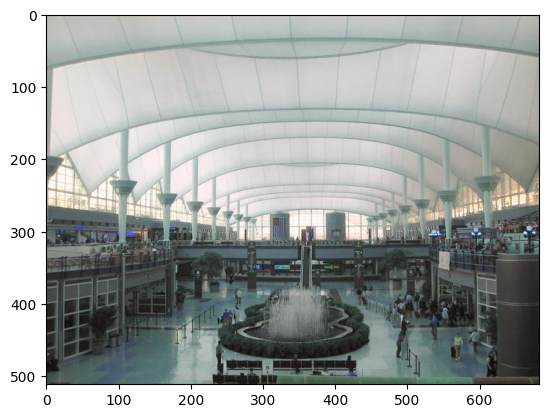

In [10]:
img = cv2.imread(train_images_path[0])
plt.imshow(img)

[1 0 1]


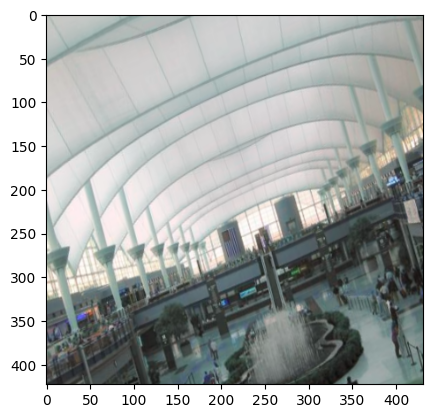

In [11]:
img2, label = transform_image(img)
plt.imshow(img2)
print(label)

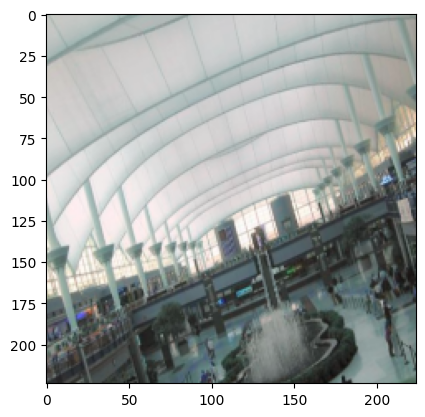

In [12]:
resized_image = cv2.resize(img2, (224, 224)) 
plt.imshow(resized_image)

In [13]:
import shutil
create_changes_images('/kaggle/working/ADEChallengeData2016/images/training/',train = True)

Saving changed images |██████████████████████████████████████████████████| 100.0% Complete


In [14]:
create_changes_images('/kaggle/working/ADEChallengeData2016/images/validation/',train = False)

Saving changed images |██████████████████████████████████████████████████| 100.0% Complete


In [15]:
create_changes_images_test('/kaggle/working/release_test/testing/')

/kaggle/working/release_test/changed_test
Saving changed images |██████████████████████████████████████████████████| 100.0% Complete


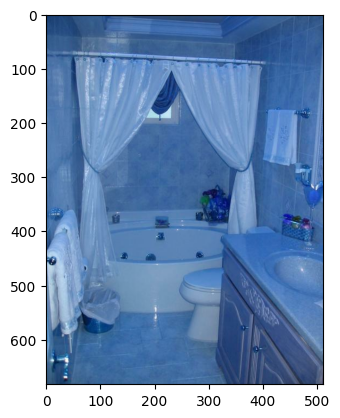

In [16]:
img = cv2.imread('/kaggle/working/ADEChallengeData2016/images/training/ADE_train_00000153.jpg')
plt.imshow(img)

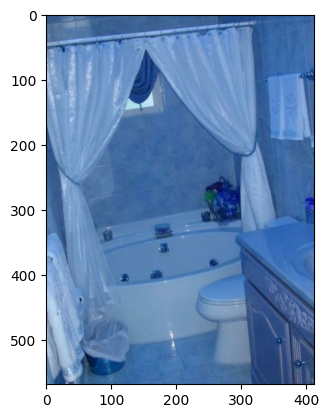

In [17]:
img = cv2.imread('/kaggle/working/ADEChallengeData2016/images/changed_train/ADE_train_00000153.jpg')
plt.imshow(img)

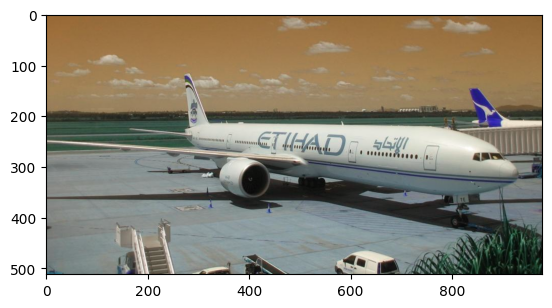

In [18]:
img = cv2.imread('/kaggle/working/release_test/testing/ADE_test_00000002.jpg')
plt.imshow(img)

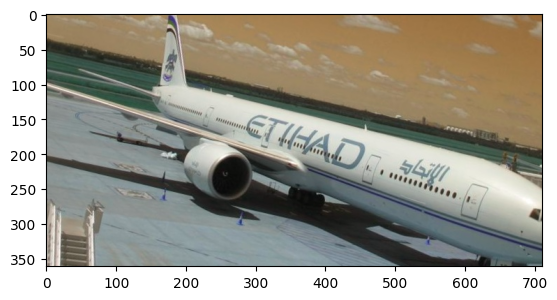

In [19]:
img = cv2.imread('/kaggle/working/release_test/changed_test/ADE_test_00000002.jpg')
plt.imshow(img)

In [20]:
train_images_path = sort_paths(glob.glob('/kaggle/working/ADEChallengeData2016/images/training/*.jpg'))
train_images_changed_path = sort_paths(glob.glob('/kaggle/working/ADEChallengeData2016/images/changed_train/*.jpg'))
valid_images_path = sort_paths(glob.glob('/kaggle/working/ADEChallengeData2016/images/validation/*.jpg'))
valid_images_changed_path = sort_paths(glob.glob('/kaggle/working/ADEChallengeData2016/images/changed_val/*.jpg'))
test_images_path = sort_paths(glob.glob('/kaggle/working/release_test/testing/*.jpg'))
test_images_changed_path = sort_paths(glob.glob('/kaggle/working/release_test/changed_test/*.jpg'))

In [21]:
print(test_images_path[-1])
print(len(test_images_path))

/kaggle/working/release_test/testing/ADE_test_00003489.jpg
3352


Found that `test_images_path` has 3352 data but 3489 index , so some of the data is missing and we should remove them from the dataset.

In [22]:

def create_changes_images_test_2(path):
    # Load the dataset
    image_paths = sort_paths(glob.glob(os.path.join(path, '*.jpg')))

    parent_dir = os.path.dirname(os.path.dirname(path))
    path = os.path.join(parent_dir,'changed_test')
    print(path)
    if os.path.exists(path):
        # If it does, remove it
        shutil.rmtree(path)
    # Create the folder
    os.makedirs(path)

    # Labels
    labels = []
    lenght = len(image_paths)
    for i in range(lenght):
        image = cv2.imread(image_paths[i])
        if image is not None:
            # Change imaeges using transform_image function and create label
            img, label = transform_image(image)
            
            # The string to extract from
            s = test_images_path[i]

            # The regular expression pattern
            pattern = r'\d+(?=\.)'

            # Find the last number in the string
            match = re.search(pattern, s)
            if match:
                last_number = match.group()
                
            # Save the image on HDD
            cv2.imwrite(os.path.join(path, 'ADE_test_{}.jpg'.format(str(last_number))), img)
            # Save the label
            labels.append(label)
            print_progress_bar(i+1, lenght, prefix = 'Saving changed images', suffix = 'Complete', length = 50)
            del image
    
    # Save the labels on HDD
    np.save(os.path.join(path, 'test_labels.npy'), labels)
    mem = psutil.virtual_memory()
    


In [23]:
import re

create_changes_images_test_2('/kaggle/working/release_test/testing/')

/kaggle/working/release_test/changed_test
Saving changed images |██████████████████████████████████████████████████| 100.0% Complete


Example of the missing data:

In [24]:
try:
    img = cv2.imread('/kaggle/working/release_test/changed_test/ADE_test_00000009.jpg')
except Exception as e:
    print(e)
            
try:
    img = cv2.imread('/kaggle/working/release_test/testing/ADE_test_00000009.jpg')
except Exception as e:
    print(e)

[ WARN:0@303.517] global loadsave.cpp:248 findDecoder imread_('/kaggle/working/release_test/changed_test/ADE_test_00000009.jpg'): can't open/read file: check file path/integrity
[ WARN:0@303.518] global loadsave.cpp:248 findDecoder imread_('/kaggle/working/release_test/testing/ADE_test_00000009.jpg'): can't open/read file: check file path/integrity


In [25]:
test_images_path = sort_paths(glob.glob('/kaggle/working/release_test/testing/*.jpg'))
test_images_changed_path = sort_paths(glob.glob('/kaggle/working/release_test/changed_test/*.jpg'))

In [26]:
dataset_train = CustomDataset(train_images_path,train_images_changed_path,
                             '/kaggle/working/ADEChallengeData2016/images/train_labels.npy')
dataset_val = CustomDataset(valid_images_path,valid_images_changed_path,
                            '/kaggle/working/ADEChallengeData2016/images/valid_labels.npy')
dataset_test = CustomDataset(test_images_path,test_images_changed_path,
                            '/kaggle/working/release_test/test_labels.npy')

# Send dataset to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size=32
num_workers=4
pin_memory=True

train_loader = DataLoader(dataset_train, 
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True  )
test_loader= DataLoader(dataset_test, 
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False)
val_loader = DataLoader(dataset_val, 
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False)


Using device: cuda


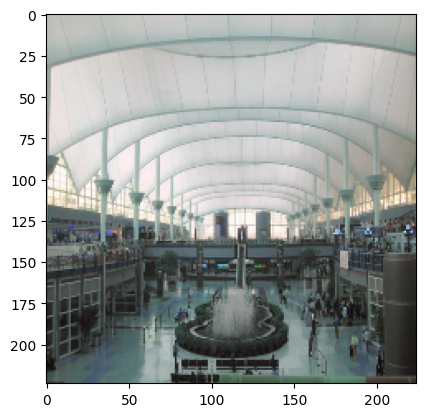

In [27]:
plt.imshow(dataset_train[0][0].permute((1,2,0)))

tensor([1, 1, 0])


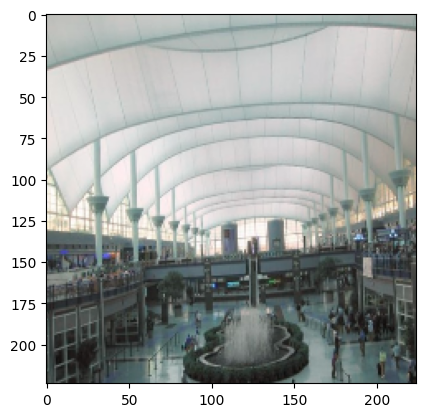

In [28]:
plt.imshow(dataset_train[0][1].permute((1,2,0)))
print(dataset_train[0][2])

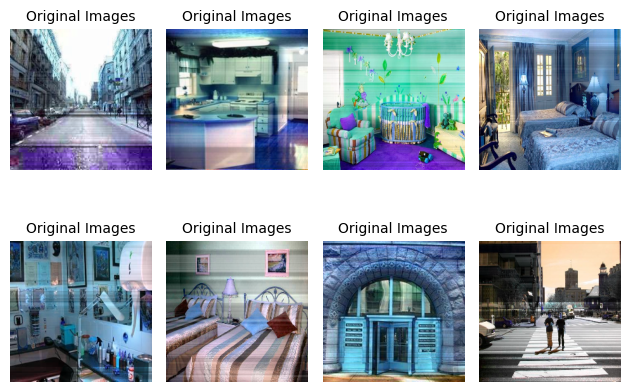

In [29]:
# Define the number of images to display
num_images = 8
# Unchanged images of train loader
for i, batch in enumerate(train_loader):
    img = batch[0]
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        image = img.numpy()[i,:]
        image = image.transpose(1, 2, 0)
        # normalise image
        data_min = np.min(image, axis=(1,2), keepdims=True)
        data_max = np.max(image, axis=(1,2), keepdims=True)
        scaled_data = (image - data_min) / (data_max - data_min)
        # show image
        plt.imshow(scaled_data)
        plt.title('Original Images', fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

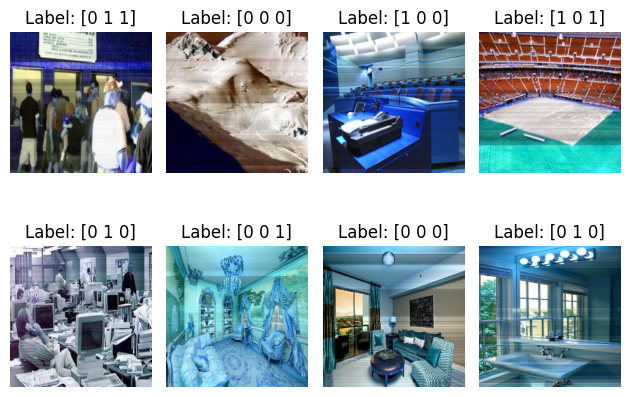

In [30]:
# Changed images of train loader
for i, batch in enumerate(train_loader):
    img = batch[1]
    labels = batch[2]
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        image = img.numpy()[i,:]
        image = image.transpose(1, 2, 0)
        # normalise image
        data_min = np.min(image, axis=(1,2), keepdims=True)
        data_max = np.max(image, axis=(1,2), keepdims=True)
        scaled_data = (image - data_min) / (data_max - data_min)
        # show image
        plt.imshow(scaled_data)
        label = labels[i].numpy()
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

**Labels explanation:** 


['rotations', 'displacement', 'scaling']

/tmp/ipykernel_42/431057032.py:11: RuntimeWarning: invalid value encountered in divide
  scaled_data = (image - data_min) / (data_max - data_min)
/opt/conda/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


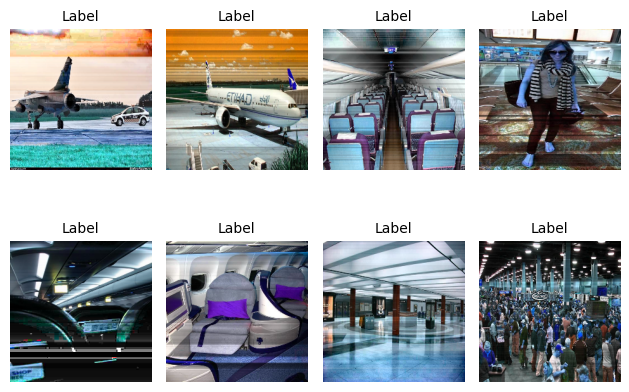

In [31]:
# Unchanged images of test loader
for i, batch in enumerate(test_loader):
    img = batch[0]
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        image = img.numpy()[i,:]
        image = image.transpose(1, 2, 0)
        # normalise image
        data_min = np.min(image, axis=(1,2), keepdims=True)
        data_max = np.max(image, axis=(1,2), keepdims=True)
        scaled_data = (image - data_min) / (data_max - data_min)
        # show image
        plt.imshow(scaled_data)
        plt.title('Label', fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

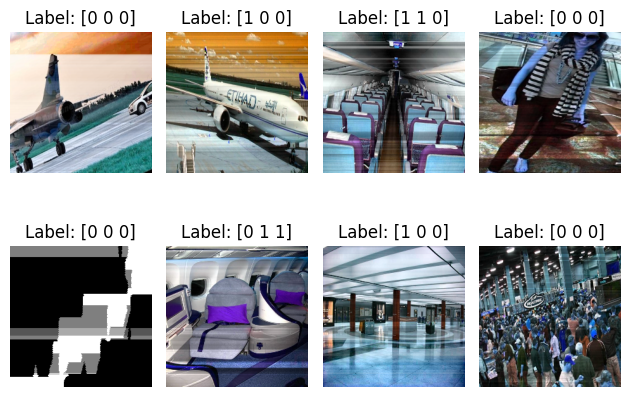

In [32]:
# Changed images of test loader
for i, batch in enumerate(test_loader):
    original_image,changed_image,labels = batch
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        image = changed_image.numpy()[i,:]
        image = image.transpose(1, 2, 0)
        # normalise image
        data_min = np.min(image, axis=(1,2), keepdims=True)
        data_max = np.max(image, axis=(1,2), keepdims=True)
        if (data_max - data_min).all()!=0 :
            scaled_data = (image - data_min) / (data_max - data_min)
        else:
            scaled_data = image
        # show image
        plt.imshow(scaled_data)
        label = labels[i].numpy()
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

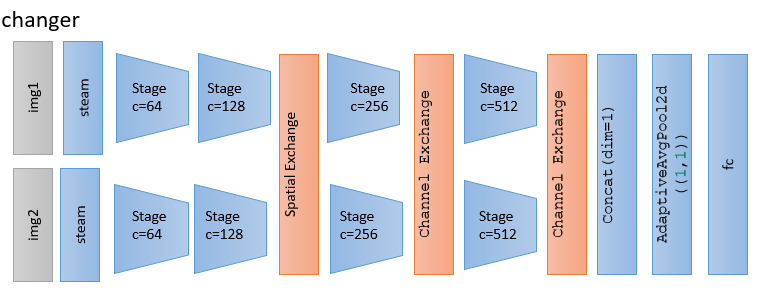

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


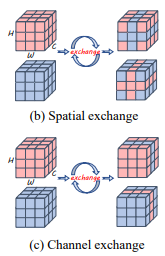

In [33]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

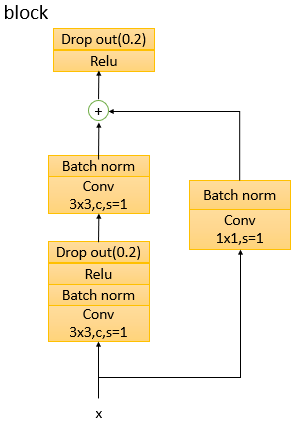

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟

question 1:
1.  How much do you consider the following values for convolution layers?

 channel out size (conv(1*1))
 
 padding(conv)
2.  What is the reason for using 1*1 convolution?

پاسخ:
1.  در لایه های کانولوشن از مقادیر زیر استفاده شده است:
 channel out size (conv(1*1))= 32
 padding(conv)= 1
2.  دلیل استفاده از کانولوشن 1در1 این است که میخواهیم تعداد کانال ها را کاهش دهیم و از این طریق میتوانیم از اورفیت جلوگیری کنیم.

Answer:
1.  The following values have been used in the convolution layers:

 channel out size (conv(1*1))= 32
 
 padding(conv)= 1
 
2.  The reason for using 1*1 convolution is that we want to reduce the number of channels and in this way we can prevent overfitting.



In [34]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # Dropout
        self.dropout = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv1x1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1x1 = nn.BatchNorm2d(out_channels)
    def forward(self,x):
        out1 = self.conv1x1(x)
        out1 = self.bn1x1(out1)
        residaul = out1
        out2 = self.conv1(x)
        out2 = self.bn1(out2)
        out2 = self.relu(out2)
        out2 = self.dropout(out2)
        out2 = self.conv2(out2)
        out2 = self.bn2(out2)
        out = out2 + residaul
        out = self.relu(out)
        out = self.dropout(out)
        return out

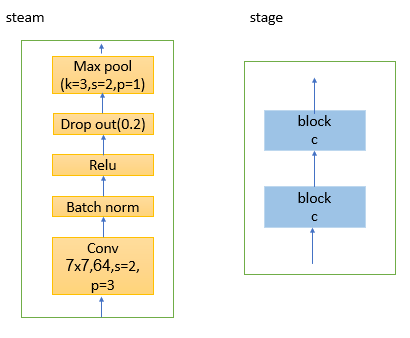

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [35]:
#To Do
class changer(nn.Module):
    def __init__(self,block,SpatialExchange,ChannelExchange):
        super(changer,self).__init__()

        self.steam=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=7,stride=2,padding=3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
            )

        self.stage1= self._make_stage(block,64,2,1)
        self.stage2=self._make_stage(block,128,2,2)
        self.stage3=self._make_stage(block,256,2,2)
        self.stage4=self._make_stage(block,512,2,2)

        self.SpatialExchange=SpatialExchange()
        self.ChannelExchange=ChannelExchange()
        # adaptive average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Output layer
        self.output_layer = nn.Sequential(
            nn.Linear(2048, 3),  # n is the number of inputs to this layer
            nn.Sigmoid()
        )

    def _make_stage(self,block,planes,num_blocks,stride):
        layers = []
        layers.append(block(planes,planes*2,stride))
        for i in range(1,num_blocks):
            layers.append(block(planes*2,planes*2,stride=1))
        return nn.Sequential(*layers)



    def forward(self,x1,x2):
        x1=self.steam(x1)
        x2=self.steam(x2)
        x1=self.stage1(x1)
        x2=self.stage1(x2)
        x1=self.stage2(x1)
        x2=self.stage2(x2)
        x1,x2=self.SpatialExchange(x1,x2)
        x1=self.stage3(x1)
        x2=self.stage3(x2)
        x1,x2=self.ChannelExchange(x1,x2)
        x1=self.stage4(x1)
        x2=self.stage4(x2)
        x1,x2=self.ChannelExchange(x1,x2)
        out=torch.cat((x1,x2),dim=1)
        out=self.avgpool(out)
        out=out.view(out.size(0),-1)
        out=self.output_layer(out)
        return out

In [36]:
## To Do
model=changer(Block,SpatialExchange,ChannelExchange).to(device)

citeration = nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(),lr=0.001)

Show model layer by layer by using the following code:

```python
print(model.layers)
```
or 
```python
print(model)
```

In [37]:
print(model)

changer(
  (steam): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (dropout): Dropout(p=0.2, inplace=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1x1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1x1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affi

Initialize random data and predict the output of the model for this data to if the model is correct or not.



In [38]:
x1 = torch.randn(32,3,224,224).to(device)
x2 = torch.randn(32,3,224,224).to(device)

In [39]:
print(model(x1,x2).shape)

torch.Size([32, 3])


So the model works

In [40]:
import gc
torch.cuda.empty_cache()
gc.collect()

mem = psutil.virtual_memory()

##Train & validation


In [42]:
Loss_train=[]
Loss_val=[]

for epoch in range(10):
    model.train()
    Sum_loss=0
    num_correct_train=0
    for i,data in enumerate(train_loader):
        original_images,changed_images,labels = data
        original_images = original_images.to(device)
        changed_images=changed_images.to(device)
        labels=labels.to(device).float()
        optimizer.zero_grad()
        outputs=model(original_images,changed_images)
        loss=citeration(outputs,labels)
        loss.backward()
        optimizer.step()
        Sum_loss+=loss.item()
        preds = outputs.round()
        num_correct_train+=(preds==labels).sum().item()
        print_progress_bar(i+1, len(train_loader), prefix = 'Training', suffix = 'Complete', length = 50)
    loss_val=0

    model.eval()
    num_correct_val=0
    with torch.no_grad():
        for i,data in enumerate(val_loader):
            original_images,changed_images,labels = data
            original_images = original_images.to(device)
            changed_images=changed_images.to(device)
            labels=labels.to(device).float()
            outputs=model(original_images,changed_images)
            loss=citeration(outputs,labels)
            loss_val+=loss.item()
            preds = outputs.round()
            num_correct_val+=(preds==labels).sum().item()
    Loss_train.append(Sum_loss)
    Loss_val.append(loss_val)
    print(f'loss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train/(3* len(train_loader.dataset)))},\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val/(3* len(val_loader.dataset)))}')


Training |██████████████████████████████████████████████████| 100.0% Complete
loss_TRAIN =816.498,acc_train=0.6162955632525152,	 loss_val= 81.839, acc_val=0.699
Training |██████████████████████████████████████████████████| 100.0% Complete
loss_TRAIN =766.297,acc_train=0.7217384133267359,	 loss_val= 83.709, acc_val=0.6811666666666667
Training |██████████████████████████████████████████████████| 100.0% Complete
loss_TRAIN =741.145,acc_train=0.7659574468085106,	 loss_val= 80.827, acc_val=0.7006666666666667
Training |██████████████████████████████████████████████████| 100.0% Complete
loss_TRAIN =725.611,acc_train=0.784380669635494,	 loss_val= 79.711, acc_val=0.722
Training |██████████████████████████████████████████████████| 100.0% Complete
loss_TRAIN =712.766,acc_train=0.8024740227610094,	 loss_val= 78.748, acc_val=0.7271666666666666
Training |██████████████████████████████████████████████████| 100.0% Complete
loss_TRAIN =704.278,acc_train=0.8127659574468085,	 loss_val= 75.905, acc_val=0.

#Test


In [43]:
# checkpoint = torch.load('#To Do')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

# ## To Do test

model.eval()
test_loss = 0
num_correct_test = 0

with torch.no_grad():
    for i, data in enumerate(test_loader):
        original_images,changed_images,labels = data
        original_images = original_images.to(device)
        changed_images=changed_images.to(device)
        labels=labels.to(device).float()
        outputs=model(original_images,changed_images)
        test_loss += citeration(outputs, labels).item()
        preds = outputs.round()
        num_correct_test+=(preds==labels).sum().item()

test_loss /= 3*len(test_loader.dataset)
test_accuracy = num_correct_test /(3* len(test_loader.dataset))

print(f'loss_test = {test_loss:.3f}, acc_test = {test_accuracy:.3f}')



loss_test = 0.016, acc_test = 0.490


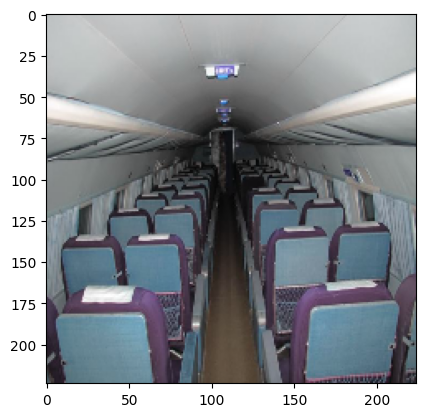

In [53]:
plt.imshow(next(iter(test_loader))[0][2].permute((1,2,0)))

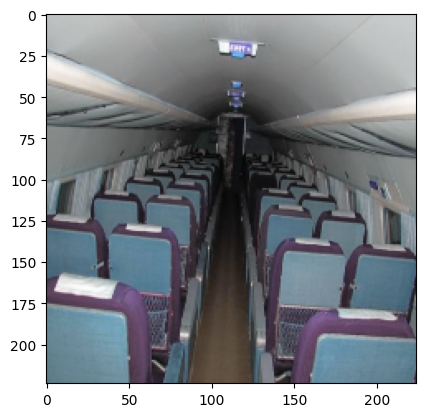

In [52]:
plt.imshow(next(iter(test_loader))[1][2].permute((1,2,0)))

In [49]:
print(next(iter(test_loader))[2][2])

tensor([1, 1, 0])


In [47]:
original_images,changed_images,labels = data
original_images = original_images.to(device)
changed_images=changed_images.to(device)
labels=labels.to(device).float()
outputs=model(original_images,changed_images)

In [51]:
print(outputs[2].round().to(device))

tensor([1., 1., 0.], device='cuda:0', grad_fn=<RoundBackward0>)


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟

In [56]:
preds = outputs.round()
correct = preds.eq(labels)

In [62]:
print(correct.cpu().numpy().sum(axis=0))

[13 13  9]


In [77]:
index1 = np.where(labels.cpu().numpy().sum(axis=1) == 1)

In [93]:
index2 = np.where(labels.cpu().numpy().sum(axis=1) == 2)

In [94]:
print(labels[index1[0][0]])
print(labels[index2[0][0]])

tensor([0., 1., 0.], device='cuda:0')
tensor([0., 1., 1.], device='cuda:0')


In [116]:
print(f'accuracy for images with one change = {correct.cpu().numpy()[index1[0]].sum()/(3*len(correct.cpu().numpy()[index1[0]])):.3f}')
print(f'accuracy for images with two changes = {correct.cpu().numpy()[index2[0]].sum()/(3*len(correct.cpu().numpy()[index2[0]])):.3f}')

accuracy for images with one change = 0.400
accuracy for images with two changes = 0.538


In [115]:
# Calculate accuracy for each change
for i in range(3):
    print(f'accuracy for change {i+1} = {correct.cpu().numpy()[:,i].sum()/(3*len(correct.cpu().numpy()[:,i])):.3f}')

accuracy for change 1 = 0.181
accuracy for change 2 = 0.181
accuracy for change 3 = 0.125


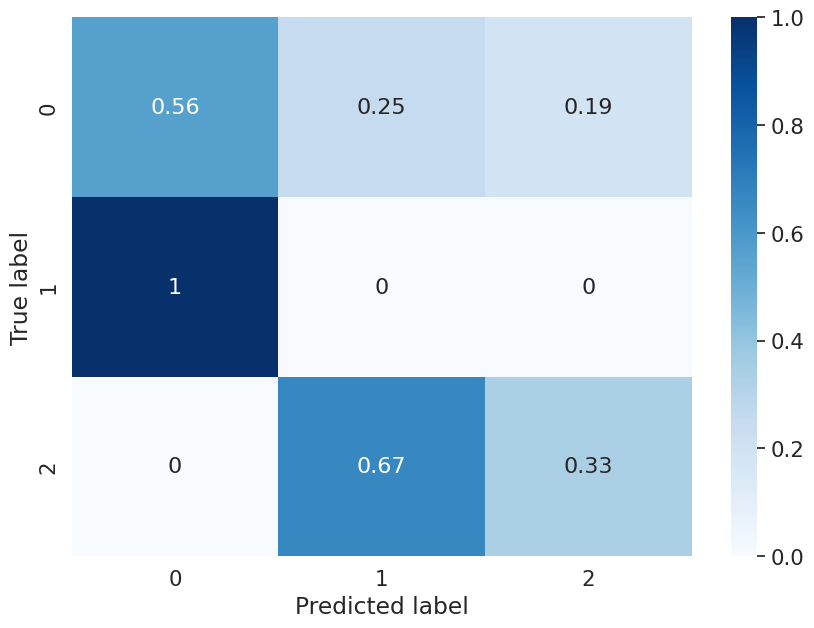

In [119]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

preds = preds.cpu()
labels = labels.cpu()

cm = confusion_matrix(labels.cpu().numpy().argmax(axis=1), preds.detach().cpu().numpy().argmax(axis=1))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, range(3), range(3))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues') # font size
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Theory question:
Check which images are better recognized with one, 2 or 3 changes?(3 changes dismissed)

Answer:
model works quite well with 1 change, but with 2 changes it works better.
